In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc


In [2]:
# Ignore any warning
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load data
factors = pd.read_csv('./datasets/covid-state-data-agg/COVID19_state.csv')
covid_cases = pd.read_csv('./datasets/covid-cases-data/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')
red_blue = pd.read_csv('./BlueRedStates.csv')
trips = pd.read_csv('./datasets/bts-travel-data/State_trips.csv')

In [4]:
# Check out factors data
factors.head()

,State,Tested,Infected,Deaths,Population,Pop Density,Gini,ICU Beds,Income,GDP,...,Hospitals,Health Spending,Pollution,Med-Large Airports,Temperature,Urban,Age 0-25,Age 26-54,Age 55+,School Closure Date
0,Alaska,620170,17057,84,734002,1.2863,0.4081,119,59687,73205,...,21,11064,6.4,1.0,26.6,66.0,0.36,0.39,0.25,03/19/20
1,Alabama,1356420,194892,2973,4908621,96.9221,0.4847,1533,42334,45219,...,101,7281,8.1,1.0,62.8,59.0,0.33,0.37,0.31,03/16/20
2,Arkansas,1363429,113641,1985,3038999,58.4030,0.4719,732,42566,42454,...,88,7408,7.1,0.0,60.4,56.2,0.34,0.37,0.30,03/17/20
3,Arizona,1792602,248139,5982,7378494,64.9550,0.4713,1559,43650,48055,...,83,6452,9.7,1.0,60.3,89.8,0.33,0.36,0.30,03/16/20
4,California,18912501,930628,17672,39937489,256.3727,0.4899,7338,62586,74205,...,359,7549,12.8,9.0,59.4,95.0,0.33,0.40,0.26,03/19/20


In [5]:
# Check out covid_cases data
covid_cases.head()

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
0,02/12/2021,UT,359641,359641.0,0.0,1060.0,0.0,1785,1729.0,56.0,11.0,2.0,02/13/2021 02:50:08 PM,Agree,Agree
1,03/01/2021,CO,438745,411869.0,26876.0,677.0,60.0,5952,5218.0,734.0,1.0,0.0,03/01/2021 12:00:00 AM,Agree,Agree
2,08/22/2020,AR,56199,NaN,NaN,547.0,0.0,674,NaN,NaN,11.0,0.0,08/23/2020 02:15:28 PM,Not agree,Not agree
3,07/17/2020,MP,37,37.0,0.0,1.0,0.0,2,2.0,0.0,0.0,0.0,07/19/2020 12:00:00 AM,Agree,Agree
4,08/12/2020,AS,0,NaN,NaN,0.0,0.0,0,NaN,NaN,0.0,0.0,08/13/2020 02:12:28 PM,NaN,NaN


In [6]:
covid_cases['submission_date'] = pd.to_datetime(covid_cases['submission_date'])

In [7]:
covid_cases = covid_cases.sort_values(by='submission_date', ascending = True)

In [8]:
covid_cases.head()

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
34662,2020-01-22,OK,0,NaN,NaN,0.0,NaN,0,NaN,NaN,0.0,NaN,03/26/2020 04:22:39 PM,Not agree,Agree
37346,2020-01-22,AK,0,NaN,NaN,0.0,NaN,0,NaN,NaN,0.0,NaN,03/26/2020 04:22:39 PM,NaN,NaN
14129,2020-01-22,GU,0,NaN,NaN,0.0,NaN,0,NaN,NaN,0.0,NaN,03/26/2020 04:22:39 PM,Not agree,Not agree
23524,2020-01-22,VT,0,NaN,NaN,0.0,NaN,0,NaN,NaN,0.0,NaN,03/26/2020 04:22:39 PM,Not agree,Not agree
29492,2020-01-22,VA,0,NaN,NaN,0.0,NaN,0,NaN,NaN,0.0,NaN,03/26/2020 04:22:39 PM,Agree,Agree


In [9]:
# Select rows for 2020 only
covid_cases2 = covid_cases.loc[(covid_cases['submission_date'] < '2021-01-01')]

In [10]:
# Group by each state and sum new_cases
tot_cases = covid_cases2.groupby('state').sum()[['new_case']]
# Agreggate NYC into NY
tot_cases['new_case']['NY'] = sum(tot_cases.loc['NYC'], tot_cases.loc['NY'])

In [11]:
red_blue.head()

,stateName,stateCode,BlueRed
0,Arizona,AZ,B
1,California,CA,B
2,Colorado,CO,B
3,Connecticut,CT,B
4,Delaware,DE,B


In [12]:
# Merge BlueRed State with tot_cases data
BR_totcases = tot_cases.merge(red_blue, left_on='state', right_on='stateCode')

In [13]:
# Merge BR_totcases with factors data
factors_BR_totcases = BR_totcases.merge(factors, left_on='stateName', right_on='State')

In [14]:
# Normalize cases for each state
factors_BR_totcases['Case Rates'] = factors_BR_totcases['new_case']/factors_BR_totcases['Population']

In [15]:
# Select for 2020 data only
trips['Date'] = pd.to_datetime(trips['Date'])
trips2 = trips.loc[((trips['Date'] < '2021-01-01') & (trips['Date'] > '2019-12-31'))]

In [16]:
#trips2['Number of Trips'] = trips2['Number of Trips'].astype('str')
#trips2['Number of Trips'] = trips2['Number of Trips'].replace(',', '')

# Replace all commas with none
trips2['Number of Trips'].replace(',','', regex=True, inplace=True)
# Make the columns numeric
trips2['Number of Trips'] = trips2['Number of Trips'].apply(pd.to_numeric,errors='coerce')
# Group by each state and sum the number of trips
trips3 = trips2.groupby('State Postal Code').sum()[['Number of Trips']]

In [17]:
# Merge factors_BR_totcases with trips aggregate data into final data table
final_data = factors_BR_totcases.merge(trips3, left_on='stateCode', right_on='State Postal Code')
final_data['Travel Rates'] = final_data['Number of Trips']/final_data['Population']

In [18]:
# Set stateCode as index
final_data.set_index('stateCode',inplace=True)

In [19]:
# Select relevant columns for analysis
clean_data = final_data.drop(columns = ['new_case','stateName','State','Tested','Infected','Deaths','Pop Density',
                                        'Flu Deaths','Respiratory Deaths','School Closure Date', 'Number of Trips'])

In [20]:
clean_data.corr()

,Population,Gini,ICU Beds,Income,GDP,Unemployment,Sex Ratio,Smoking Rate,Physicians,Hospitals,Health Spending,Pollution,Med-Large Airports,Temperature,Urban,Age 0-25,Age 26-54,Age 55+,Case Rates,Travel Rates
Population,1.000000,0.489153,0.977777,0.209982,0.239292,0.056601,-0.231239,-0.253963,0.950090,0.871706,-0.192039,0.614910,0.926917,0.357940,0.449917,0.041088,0.439364,-0.286929,-0.132673,-0.182759
Gini,0.489153,1.000000,0.525640,0.039587,-0.031954,0.209380,-0.666283,0.149586,0.552587,0.409587,-0.081117,0.353152,0.359948,0.506835,0.178469,-0.233470,0.188732,0.139431,-0.065060,0.159023
ICU Beds,0.977777,0.525640,1.000000,0.126107,0.153102,0.065429,-0.286387,-0.132029,0.927856,0.888210,-0.211876,0.614208,0.915420,0.410413,0.422019,0.040795,0.397757,-0.251051,-0.090235,-0.144079
Income,0.209982,0.039587,0.126107,1.000000,0.886935,-0.122642,0.113816,-0.578860,0.353439,-0.024489,0.535438,-0.117286,0.194902,-0.361070,0.459420,-0.321554,0.488891,0.002390,-0.260566,0.276087
GDP,0.239292,-0.031954,0.153102,0.886935,1.000000,-0.076271,0.181340,-0.519444,0.370516,0.052185,0.501020,-0.044363,0.215272,-0.343662,0.510665,-0.118241,0.527030,-0.197398,-0.108380,0.249295
Unemployment,0.056601,0.209380,0.065429,-0.122642,-0.076271,1.000000,-0.050725,0.435496,0.088856,0.092155,0.147367,0.307559,0.050503,0.008140,-0.029129,0.021113,0.001858,-0.051017,-0.019041,-0.069488
Sex Ratio,-0.231239,-0.666283,-0.286387,0.113816,0.181340,-0.050725,1.000000,-0.124306,-0.277989,-0.171933,0.116936,-0.330909,-0.134672,-0.675553,-0.123240,0.330431,-0.071815,-0.275038,0.312873,-0.164675
Smoking Rate,-0.253963,0.149586,-0.132029,-0.578860,-0.519444,0.435496,-0.124306,1.000000,-0.275156,-0.026140,0.051128,-0.041518,-0.274076,0.124497,-0.606205,0.031118,-0.337320,0.196889,0.212825,0.079043
Physicians,0.950090,0.552587,0.927856,0.353439,0.370516,0.088856,-0.277989,-0.275156,1.000000,0.769297,-0.028213,0.560669,0.850339,0.236641,0.479681,-0.057781,0.450284,-0.201409,-0.167838,-0.024783
Hospitals,0.871706,0.409587,0.888210,-0.024489,0.052185,0.092155,-0.171933,-0.026140,0.769297,1.000000,-0.275708,0.539095,0.778483,0.387575,0.266901,0.230479,0.264597,-0.368739,0.037703,-0.168371


In [21]:
# Drop Population column as well
# Dropped correlations between couple variables
clean_data = clean_data.drop(columns = ['Population'])
clean_data.corr()

,Gini,ICU Beds,Income,GDP,Unemployment,Sex Ratio,Smoking Rate,Physicians,Hospitals,Health Spending,Pollution,Med-Large Airports,Temperature,Urban,Age 0-25,Age 26-54,Age 55+,Case Rates,Travel Rates
Gini,1.000000,0.525640,0.039587,-0.031954,0.209380,-0.666283,0.149586,0.552587,0.409587,-0.081117,0.353152,0.359948,0.506835,0.178469,-0.233470,0.188732,0.139431,-0.065060,0.159023
ICU Beds,0.525640,1.000000,0.126107,0.153102,0.065429,-0.286387,-0.132029,0.927856,0.888210,-0.211876,0.614208,0.915420,0.410413,0.422019,0.040795,0.397757,-0.251051,-0.090235,-0.144079
Income,0.039587,0.126107,1.000000,0.886935,-0.122642,0.113816,-0.578860,0.353439,-0.024489,0.535438,-0.117286,0.194902,-0.361070,0.459420,-0.321554,0.488891,0.002390,-0.260566,0.276087
GDP,-0.031954,0.153102,0.886935,1.000000,-0.076271,0.181340,-0.519444,0.370516,0.052185,0.501020,-0.044363,0.215272,-0.343662,0.510665,-0.118241,0.527030,-0.197398,-0.108380,0.249295
Unemployment,0.209380,0.065429,-0.122642,-0.076271,1.000000,-0.050725,0.435496,0.088856,0.092155,0.147367,0.307559,0.050503,0.008140,-0.029129,0.021113,0.001858,-0.051017,-0.019041,-0.069488
Sex Ratio,-0.666283,-0.286387,0.113816,0.181340,-0.050725,1.000000,-0.124306,-0.277989,-0.171933,0.116936,-0.330909,-0.134672,-0.675553,-0.123240,0.330431,-0.071815,-0.275038,0.312873,-0.164675
Smoking Rate,0.149586,-0.132029,-0.578860,-0.519444,0.435496,-0.124306,1.000000,-0.275156,-0.026140,0.051128,-0.041518,-0.274076,0.124497,-0.606205,0.031118,-0.337320,0.196889,0.212825,0.079043
Physicians,0.552587,0.927856,0.353439,0.370516,0.088856,-0.277989,-0.275156,1.000000,0.769297,-0.028213,0.560669,0.850339,0.236641,0.479681,-0.057781,0.450284,-0.201409,-0.167838,-0.024783
Hospitals,0.409587,0.888210,-0.024489,0.052185,0.092155,-0.171933,-0.026140,0.769297,1.000000,-0.275708,0.539095,0.778483,0.387575,0.266901,0.230479,0.264597,-0.368739,0.037703,-0.168371
Health Spending,-0.081117,-0.211876,0.535438,0.501020,0.147367,0.116936,0.051128,-0.028213,-0.275708,1.000000,-0.377795,-0.171802,-0.559658,-0.200392,-0.511958,-0.000621,0.457156,-0.150237,0.326204


### Random Forest Model

In [22]:
### Random Forest Model
# Select Predictors and Outcome Variable
X = clean_data.copy().drop(columns = 'BlueRed')
Y = clean_data['BlueRed']

# print(X_test.shape)

# Split data for model
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, 
                                                    random_state=0)

forest = RandomForestClassifier(n_estimators = 100).fit(X_train, Y_train)
Y_pred = forest.predict(X_test)

# # Fit model to train set and do feature selection
# selector = SelectFromModel(RandomForestClassifier(n_estimators = 100))
# selector = selector.fit(X_train, Y_train)

# # To see which features are important we can use get_support method on the fitted model.
# # sel.get_support()

# # Make a list and count the selected features.
# # selected_feat= X_train.columns[(sel.get_support())]
# # len(selected_feat)

# # Get the name of the features selected
# # print(selected_feat)

# # Check and plot the distribution of importance.
# # pd.Series(sel.estimator_.feature_importances_.ravel()).hist()

# X_selected = selector.transform(X_train)
# X_test = selector.transform(X_test)
# rfc = RandomForestClassifier(n_estimators = 100, random_state=7).fit(X_selected, Y_train)

# Use model to make predictions with test set
# Y_pred = rfc.predict(X_test)

In [23]:
### Evaluation
# View accuracy score
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)

# View confusion matrix for test data and predictions
confusion_matrix(Y_test, Y_pred)

# View the classification report for test data and predictions
print(classification_report(Y_test, Y_pred))

Accuracy: 0.8
              precision    recall  f1-score   support

           B       0.80      0.80      0.80         5
           R       0.80      0.80      0.80         5

    accuracy                           0.80        10
   macro avg       0.80      0.80      0.80        10
weighted avg       0.80      0.80      0.80        10



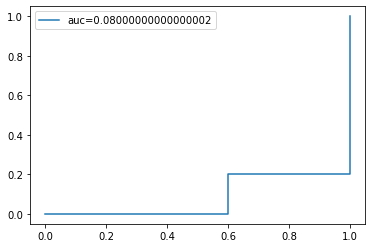

In [24]:
# Plot ROC and AUC score
Y_test_num = []
for idx in range(0, Y_test.size):
    if Y_test[idx] == 'B':
        Y_test_num.append(1)
    else:
        Y_test_num.append(0)     
        
Y_pred_proba = forest.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test_num,  Y_pred_proba)
auc = metrics.roc_auc_score(Y_test_num, Y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend()
plt.show()

### Logistic Regression

Accuracy: 0.9
              precision    recall  f1-score   support

           B       1.00      0.80      0.89         5
           R       0.83      1.00      0.91         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10



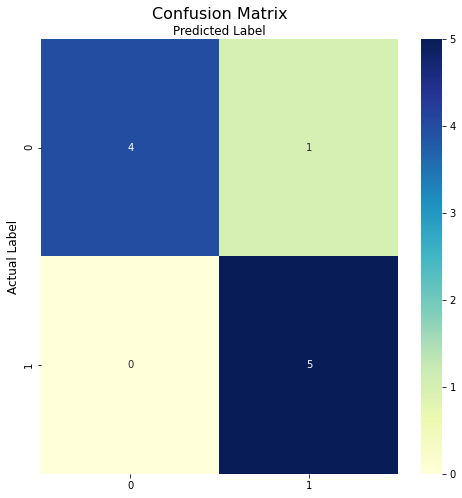

In [25]:
# Select Predictors and Outcome Variable
X = clean_data.copy().drop(columns = 'BlueRed')
Y = clean_data['BlueRed']

# Split data for model
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=1)

# Select best features and Fit model to train set
selector = SelectFromModel(estimator=LogisticRegression()).fit(X_train, 
                                                               Y_train)
coefs = selector.estimator_.coef_
thresh = selector.threshold_
support = selector.get_support()
X_selected = selector.transform(X_train)
X_test = selector.transform(X_test)
logistic = LogisticRegression(penalty='l1',solver='liblinear',
                               random_state=7).fit(X_selected, Y_train)

# Use model to make predictions with test set
Y_pred = logistic.predict(X_test)

### Evaluation
# View accuracy score
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)

# View confusion matrix for test data and predictions
confusion_matrix(Y_test, Y_pred)

# View the classification report for test data and predictions
print(classification_report(Y_test, Y_pred))
        
# Compute the model error and score
confusion = metrics.confusion_matrix(Y_test, Y_pred)
fig, ax = plt.subplots(figsize = [8,8])
sns.heatmap(confusion, annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion Matrix', size = 16)
plt.xlabel('Predicted Label', size = 12)
plt.ylabel('Actual Label', size = 12)
ax.xaxis.set_label_position("top")
plt.show()


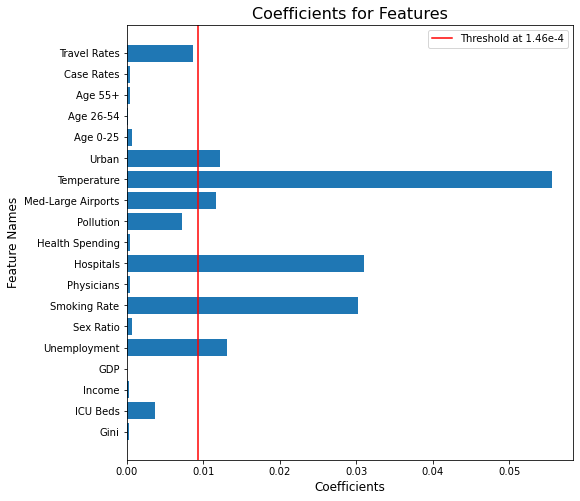

In [26]:
# Plot the betas
feature_names = X.columns
importance = abs(coefs.T[:,0])
plt.figure(figsize = (8,8))
plt.barh(np.linspace(1,len(importance),len(importance)),importance,
         tick_label=feature_names) 
plt.axvline(x=thresh, color = 'r', label = 'Threshold at 1.46e-4')
plt.title('Coefficients for Features', size = 16)
plt.xlabel('Coefficients', size = 12)
plt.ylabel('Feature Names', size = 12)
plt.legend()
plt.show()

In [27]:
# View selected features from final model
selected_features = []
for idx in range(0, len(X.columns)):
    if support[idx]:
        selected_features.append(X.columns[idx])
print('Selected Features:', selected_features)

Selected Features: ['Unemployment', 'Smoking Rate', 'Hospitals', 'Med-Large Airports', 'Temperature', 'Urban']


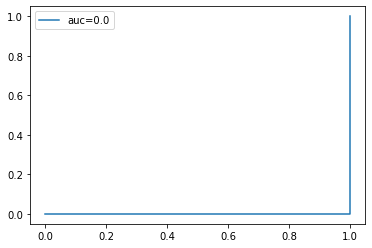

In [28]:
# Plot ROC and AUC score
Y_test_num = []
for idx in range(0, Y_test.size):
    if Y_test[idx] == 'B':
        Y_test_num.append(1)
    else:
        Y_test_num.append(0)

Y_pred_proba = logistic.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test_num,  Y_pred_proba)
auc = metrics.roc_auc_score(Y_test_num, Y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend()
plt.show()